# Logistic Regression

We consider a binary classification problem, where the dataset contains pairs of the form $(x, y)$, where $x$ is a 2D-point and $y \in \{-1, +1\}$ is the binary label.

Samples with positive labels are generated according to a normal distribution $\mathcal{N}(\mu_+, \sigma^2 I)$, with unknown mean $\mu_+$ and covariance $\sigma^2 I$. Samples with negative labels are generated according to a normal distribution $\mathcal{N}(\mu_-, \sigma^2 I)$, with unknown mean $\mu_-$ and same covariance $\sigma^2 I$.

Our goal is to fit a Logistic model to the observations by using the Gradient Descent procedure.

## Dataset generation
We start by creating the dataset we will be using for the optimization process. 

In [46]:
import numpy as np


n = 300 # Number of samples for each class
d = 2   # Dimension

mu_pos = 1. * np.ones(d)
mu_neg = -1. * np.ones(d)
sigma = 1.

X_pos = mu_pos + sigma * np.random.randn(n, d)
y_pos = np.ones(n)
X_neg = mu_neg + sigma * np.random.randn(n, d)
y_neg = -np.ones(n)

X = np.vstack((X_pos, X_neg))
y = np.hstack((y_pos, y_neg))

Let us visualize the generated points.

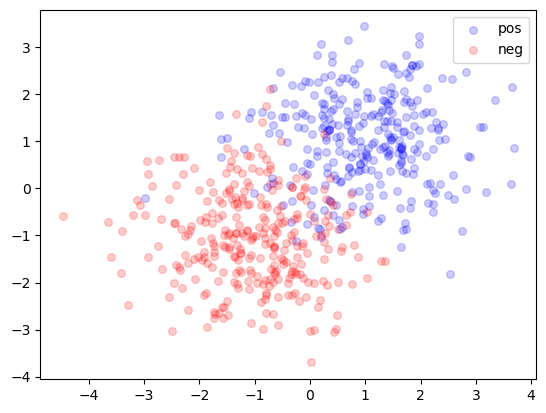

In [47]:
import matplotlib.pyplot as plt

plt.scatter(X_pos[:, 0], X_pos[:, 1], s=30, color='b', label='pos', alpha=.2)
plt.scatter(X_neg[:, 0], X_neg[:, 1], s=30, color='r', label='neg', alpha=.2)
plt.legend()
plt.show()

### Question 1
Our goal is to learn the posterior probability $\mathbb{P}(Y=+1 | X=x)$ with the following parametric model:
$$
  \mathbb{P}(Y=+1 | X=x) = \frac{\exp(w^\top x)}{1 + \exp(w^\top x)} \enspace.
$$
We use the negative log-likelihood as the loss function. Write the expression of the loss $\mathcal{L}(w)$.
 -$l$($\eta_w$)=$\frac{-1}{N}\sum_{i=1}^{N}y_i*log(\eta_w(x_i))+(1-y_i)*log(1-\eta_w(x_i))$

### Question 2
Define a function `logistic_loss(w, X, y)` computing the loss $\mathcal{L}(w)$ defined above on the dataset `(X, y)`.



In [48]:
#@ does matrix multiplication
def sigmoid(w, x):
    return 1./(1 + np.exp(-x @ w))

def logistic_loss(w, X, y):
    eta = sigmoid(w, X)
    return - np.average(y * np.log(eta) + (1 - y) * np.log(1 - eta)) 

## Gradient Descent
A popular optimization method to find a good estimate of the parameter $w^\star$ is the gradient descent. The overall idea is to start from some initial guess $w_0$, compute the gradient of the loss $\nabla \mathcal{L}$ at $w_0$ and update the parameter in the opposite direction
$$
w_1 = w_0 - \gamma \nabla\mathcal{L}(w_0) \enspace,
$$
where $\gamma > 0$ is an hyperparameter called step size. Then, the updating process is repeated for a set amount of iterations.

### Question 3
What is the gradient of $\mathcal{L}(w)$? Implement a function `gradient(w, X, y)` that returns $\nabla \mathcal{L}(w)$.

In [49]:
def gradient(w, X, y):
    grad = np.zeros(w.shape)
    for xi, yi in zip(X, y):
        eta = sigmoid(w, xi)
        grad += xi*(eta - yi)
    grad /= X.shape[0]
    return grad

The gradient descent procedure is partially defined in the function `gradient_descent(w0, step_size=1e-2, n_iter=100)` below. Complete it and test your `gradient` implementation with it.

In [56]:
def gradient_descent(w0, step_size=1e-4, n_iter=6000):
    w = w0.copy()
    loss_evolution = []
    for _ in range(n_iter):
        # TODO: Update w
        w = w - step_size *  gradient(w, X, y)       
        loss_evolution.append(logistic_loss(w, X, y))
    return w, loss_evolution

The following script runs the gradient descent procedure and plot the decision boundary.

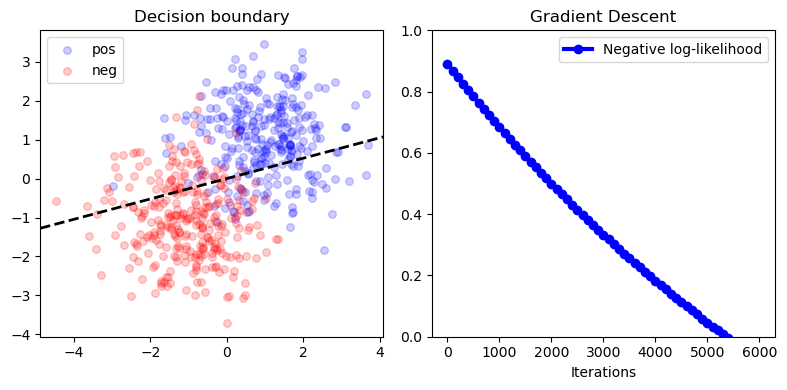

In [57]:
w0 = np.array([-1., 1.])
est_w, loss_values = gradient_descent(w0)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), layout='tight')
# Data points
axs[0].scatter(X_pos[:, 0], X_pos[:, 1], s=30, color='b', label='pos', alpha=.2)
axs[0].scatter(X_neg[:, 0], X_neg[:, 1], s=30, color='r', label='neg', alpha=.2)

# Boundary
axis_xlim = axs[0].get_xlim()
axis_ylim = axs[0].get_ylim()
axs[0].plot(axis_xlim, -np.array(axis_xlim) * est_w[0] / est_w[1],
            linewidth=2, linestyle='--', color='k')
axs[0].set_xlim(axis_xlim)
axs[0].set_ylim(axis_ylim)

axs[0].legend()
axs[0].set_title('Decision boundary')

# Loss
axs[1].plot(loss_values, linewidth=3, color='b', marker='o',
            markevery=100, label='Negative log-likelihood')
axs[1].set_ylim([0, 1.])
axs[1].set_xlabel('Iterations')
axs[1].legend()
axs[1].set_title('Gradient Descent')
plt.show()


### Question 4
Try the above procedure for different values of the `step_size`. What do you notice? Same question for $\sigma^2$.

In general, the smaller the step size, the longer it takes for the algorithm to converge. However, when I tried 1e-4, although the gradient descient graph indicates that the negative log-likelihood is 0, the the decision boundary is poor. Increasing the standard deviation makes the classification more difficult because there will be more overlap between the two categories, vice versa. 

## Stochastic Gradient Descent
Remember that the loss $\mathcal{L}$ can be written as
$$
\mathcal{L}(w) = \frac{1}{n} \sum_{i = 1}^n \ell(w; \mathbf{x}_i, y_i) \enspace,
$$
where $\ell(w; \mathbf{x}, y)$ is the negative log-likelihood associated to the sample $(\mathbf{x}_i, y_i)$.

To compute the full gradient, one has to sum $n$ partial gradients $\nabla \ell(w; \mathbf{x}_i, y_i)$. In many machine learning settings, the number of observations $n$ is much larger than a few hundreds, and computing the gradient becomes the bottleneck of the optimization process.

Stochastic Gradient Descent sacrifices accuracy in favor of a much quicker gradient computation. One way to implement it is to select uniformly at random a pair $(\mathbf{x}_i, y_i)$, compute the incomplete gradient $\nabla \ell(w; \mathbf{x}_i, y_i)$ associated to the pair and update the estimate $w$ as if it were the complete gradient. Then, at the following iteration, a pair is randomly drawn again and the estimate is again updated accordingly, _etc_.

### Bonus
Complete the SGD implementation below and compare it to the gradient descent algorithm.

In [38]:
def stochastic_gradient_descent(w0, X, y, step_size=1e-4, n_iter=200):
    w = w0.copy()
    loss_evolution = []
    for _ in range(n_iter):
        # Select a random index
        rnd_idx = np.random.randint(X.shape[0])
        # TODO: Update w
        w = w - step_size *  gradient(w, X[rnd_idx:rnd_idx + 1], y[rnd_idx:rnd_idx + 1]) 
        loss_evolution.append(logistic_loss(w, X, y))
    return w / n_iter, loss_evolution

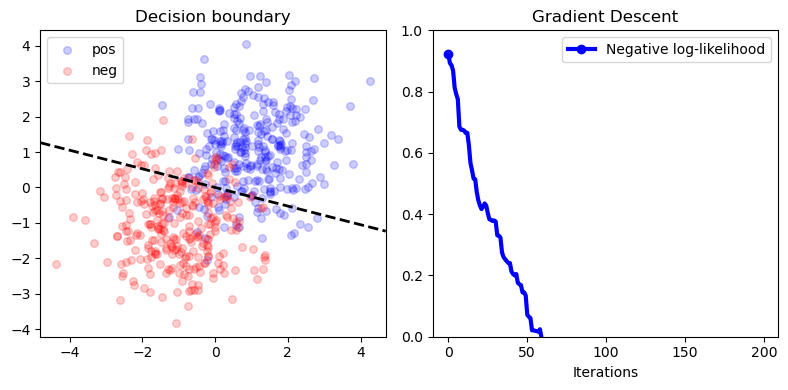

In [39]:
w0 = np.array([-1., 1.])
est_w, loss_values = stochastic_gradient_descent(w0, X, y)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), layout='tight')
# Data points
axs[0].scatter(X_pos[:, 0], X_pos[:, 1], s=30, color='b', label='pos', alpha=.2)
axs[0].scatter(X_neg[:, 0], X_neg[:, 1], s=30, color='r', label='neg', alpha=.2)

# Boundary
axis_xlim = axs[0].get_xlim()
axis_ylim = axs[0].get_ylim()
axs[0].plot(axis_xlim, -np.array(axis_xlim) * est_w[0] / est_w[1],
            linewidth=2, linestyle='--', color='k')
axs[0].set_xlim(axis_xlim)
axs[0].set_ylim(axis_ylim)

axs[0].legend()
axs[0].set_title('Decision boundary')

# Loss
axs[1].plot(loss_values, linewidth=3, color='b', marker='o',
            markevery=100, label='Negative log-likelihood')
axs[1].set_ylim([0, 1.])
axs[1].set_xlabel('Iterations')
axs[1].legend()
axs[1].set_title('Gradient Descent')
plt.show()

The SGA algorithm gave a much less smooth negative log likelihood loss evolution than the gradient descent algorithm. both took roughly the same amount of iterations to reach 0 neg log-likelihood

SGD can be further improved by selecting a mini-batch of samples instead of a unique pair. Modify the previous implementation so that it selects several indices at each iteration.

In [44]:
def stochastic_gradient_descent_multiple_indices(w0, X, y, batch_size = 30, step_size=1e-2, n_iter=200):
    w = w0.copy()
    loss_evolution = []
    n_samples = X.shape[0]
    
    for _ in range(n_iter):
        # Select a random index
        batch_indices = np.random.choice(n_samples, batch_size, replace = False)
        
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        # TODO: Update w
        w = w - step_size *  gradient(w, X_batch, y_batch) 
        loss_evolution.append(logistic_loss(w, X, y))
    return w / n_iter, loss_evolution

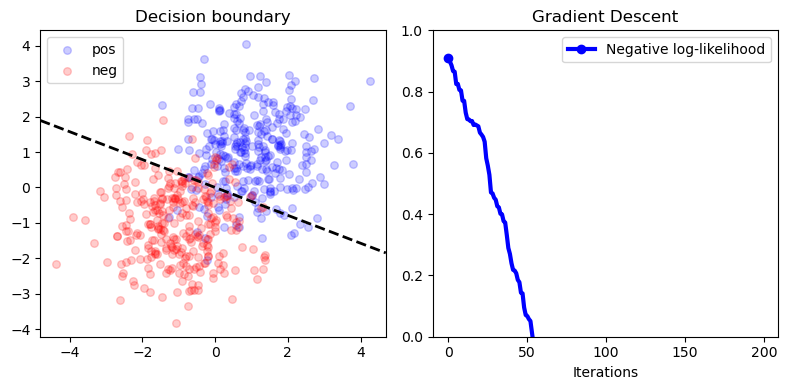

In [45]:
w0 = np.array([-1., 1.])
est_w, loss_values = stochastic_gradient_descent(w0, X, y)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), layout='tight')
# Data points
axs[0].scatter(X_pos[:, 0], X_pos[:, 1], s=30, color='b', label='pos', alpha=.2)
axs[0].scatter(X_neg[:, 0], X_neg[:, 1], s=30, color='r', label='neg', alpha=.2)

# Boundary
axis_xlim = axs[0].get_xlim()
axis_ylim = axs[0].get_ylim()
axs[0].plot(axis_xlim, -np.array(axis_xlim) * est_w[0] / est_w[1],
            linewidth=2, linestyle='--', color='k')
axs[0].set_xlim(axis_xlim)
axs[0].set_ylim(axis_ylim)

axs[0].legend()
axs[0].set_title('Decision boundary')

# Loss
axs[1].plot(loss_values, linewidth=3, color='b', marker='o',
            markevery=100, label='Negative log-likelihood')
axs[1].set_ylim([0, 1.])
axs[1].set_xlabel('Iterations')
axs[1].legend()
axs[1].set_title('Gradient Descent')
plt.show()